# Topic Modelling and Visualisation
***

## Background

Determine the degree of consensus in contentious academic fields. 

Collect title, publication date and summaries from scholarly articles containing a certain keyword or keywords. Apply NLP models to this data to identify and categorise concepts in this field and determine statistical significance between opposing 'truths', if any. Ranking these groups according to weighted influence will prove the degree of consensus of various approaches in a given academic field.

To this end the academic_consensus model has already searched the abstracts of academic papers that contain the keyword "nutrition" and saved it into corpus_raw.csv.  
  
Overview of this notebook:
- Setup notebok environment and load data (corpus_raw.csv)
- Review articles published per year (sklearn's Countvectorizer)
- Create Bag Of Words (BOW) of all articles for Titles and Conclusions (nltk)
- Create interactive BOW per year with Bokeh

### Credit

Credit due in large to Patrick Harrison: Modern NLP in Python | PyData DC 2016  
  
Thank you!

## Setup

### Packages and setup

In [1]:
# Common
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Workspace
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML

In [2]:
# Set workspace
sns.set()
# Set output charackters to 110 (not 79)
pd.options.display.width = 110
# To give multiple cell output. Not just the last command.
InteractiveShell.ast_node_interactivity = 'last'
# Make notebook wider to fit pyLDAvis plot
display(HTML("<style>.container { width:50% !important; }</style>"))

### Load and inspect corpus.csv

In [3]:
# Load corpus.csv as DataFrame with parsed date format
corpus = pd.read_csv('../data/interim/corpus_raw.csv', parse_dates=[0])

In [4]:
# Keyword 
keywords = ['nutrition', 'diet']

In [5]:
# Inspect
corpus.info()
corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 3 columns):
publication_date    1530 non-null datetime64[ns, UTC]
title               1530 non-null object
conclusions         1530 non-null object
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 36.0+ KB


,publication_date,title,conclusions
0,2016-03-09 00:00:00+00:00,Pregnancy Requires Major Changes in the Qualit...,['Pregnancy tends to markedly widen the nutrit...
1,2016-08-23 00:00:00+00:00,Continental-Scale Patterns Reveal Potential fo...,"['In all, given the geographic patterns in die..."
2,2015-06-17 00:00:00+00:00,Assessing Nutritional Parameters of Brown Bear...,['Previous studies have illustrated the differ...
3,2015-04-17 00:00:00+00:00,The Self-Reported Clinical Practice Behaviors ...,['The present study provides a valuable insigh...
4,2017-10-09 00:00:00+00:00,The impact of nutritional supplement intake on...,['Our study shows that the propensity to consu...


## Phrase Modeling 

Using Spacy to tokenise and clean each sentence in every document by removing stop words, punctuation, unnecessary white space, numbers and lemmatising each word.  
  
Do this for every sentence in each document. 
Generate a list of:
- Phrased documents
- Phrased sentences combined

In [6]:
# Necessary imports for Phrase Modeling
import spacy
from gensim.models.phrases import Phrases, Phraser
#from gensim.models.word2vec import LineSentence     - to be used when scaling

# Set Spacy
nlp = spacy.load('en_core_web_sm')

In [7]:
def docs_preclean_from_df(df, col):
    '''
    Convert documents from DataFrame and clean new line escapes and brackets.
    '''
    # Gather all articles' 'Conclusions' into docs
    docs_corp = df[col]

    # Clean unneseccary escapes and characters
    docs = []
    for doc in docs_corp:
        text = doc.replace('\'', '')
        text = text.replace('[', '')
        text = text.replace(']', '')
        text = text.replace('\\n' ,'')
        docs.append(text)
                
    return docs


In [8]:
def sents_split_from_docs(docs):
    '''
    Convert documents to list of all sentences.
    '''
#    sents = []
#    for doc in docs:
#        for sent in doc.split('.'):
#            if not sent == '':
#                sents.append(sent)
                
    #docs_clean = []
    sents_clean = []
    for parsed_doc in nlp.pipe(docs, n_process=4):   
        # For each document 
        # sents_clean_per_doc = []
        for sent in parsed_doc.sents:
            sent_token          = [token for token in sent]
            #sents_clean_per_doc += sent_token
            # Adds to corpus of sentences
            sents_clean.append(sent_token)
        

            
    return sents

In [9]:
def docs_sents_clean(docs):
    '''
    Clean corpus and produce:
    - Cleaned documents
    - Cleaned sentences combined from all documents
    '''
     # Use Spacy - pipe to parse each document, break it into sentences, 
    # clean it (lemmatise, punctuation and white space) and combine
    # all cleaned sentences into sents_clean, and 
    # all cleaned sentences per document into docs_clean

    docs_clean = []
    sents_clean = []
    sents = []
    for parsed_doc in nlp.pipe(docs, n_process=4):   
        # For each document 
        sents_clean_per_doc = []
        for sent in parsed_doc.sents:
            sent_token = []
            sent_token = [token.lemma_ for token in sent if not (token.is_stop or token.is_punct)]
            
            # Only add original sentence if sent_token is not null
            if len(sent_token) > 1:
                # Adds to corpus of sentences
                sents.append(sent)
                sents_clean.append(sent_token)
            
            sents_clean_per_doc += sent_token
           
        # Adds to corpus of ducuments
        docs_clean.append(sents_clean_per_doc)
    # Confirming output
    print('Number of documents (articles): {}'.format(len(docs_clean)))
    print('Total number of sentences: {}'.format(len(sents_clean)))
    print('Total words: {}\n'.format(sum([len(sent) for sent in sents_clean])))
    print('\nsents and sents_clean have the same length: ', len(sents) == len(sents_clean), '\n')
    
    return docs_clean, sents_clean, sents


In [10]:
def n_plus_one_gram(sents):
    ''' Generate n+1_gram model and outputs new sentences 
    Returns n+1_gram model and n+1_gram sentences'''
    # Create n+1 gram model with Gensim for all sentences
    g = Phrases(sents)
    g = Phraser(g)    
    # Generate n+1 gram sentences
    g_sents = [sent for sent in g[sents]]

    # Confirming output
    print('Total words after (n+1) gram: {}'.format(sum([len(sent) for sent in g_sents])) + '\n')
    
    return g, g_sents


In [11]:
def docs_sents_phrasing(docs_clean, sents_clean):
    '''
    Prepare documents and sentences for phrasing.
    '''
    # Phrasing SENTENCES
    # Bigram
    bg, bg_sents = n_plus_one_gram(sents_clean)
    # Trigram
    tg, tg_sents = n_plus_one_gram(bg_sents)
    
    # Phrasing DOCUMENTS
    # Fit bigrams model to the cleaned documents
    bg_docs = bg[docs_clean]
    # Fit trigrams model to converted bigrams
    tg_docs = tg[bg_docs]
    
    # Extract docs from generator
    ph_docs = [doc for doc in tg_docs]
    
    # add stopwords
    add_stopwords = ['study', 'effect', 'population', 'change', 'increase', 'different', 'high', 'level', 'low', 'result'] #food, diet
    [nlp.Defaults.stop_words.add(word) for word in add_stopwords]
                
    # Take out final stop words for each document
    phrased_docs = []
    for doc in ph_docs:
        phrased_docs.append([word for word in doc if word not in nlp.Defaults.stop_words])
    
    # Take out final stop words for each sentence (to be used later)
    phrased_sents = []
    for sent in tg_sents:
        phrased_sents.append([word for word in sent if word not in nlp.Defaults.stop_words])
    
    
    return phrased_docs, phrased_sents
    

In [12]:
# Messing around by excluding some words

nlp.Defaults.stop_words.add('study')
nlp.Defaults.stop_words.add('diet')
nlp.Defaults.stop_words.add('effect')

In [13]:
docs = docs_preclean_from_df(corpus, 'conclusions')
docs_clean, sents_clean, sents = docs_sents_clean(docs)
phrased_docs, phrased_sents = docs_sents_phrasing(docs_clean, sents_clean)

Number of documents (articles): 1530
Total number of sentences: 12464
Total words: 189133


sents and sents_clean have the same length:  True 

Total words after (n+1) gram: 177335

Total words after (n+1) gram: 175828



In [14]:
print('First 10 words from first document: \n', phrased_docs[0][:10], '\n')
print('First sentence: \n', phrased_sents[0])

First 10 words from first document: 
 ['pregnancy', 'tend', 'markedly', 'widen', 'nutritional', 'gap', 'decrease', 'nutritional', 'adequacy', 'observed'] 

First sentence: 
 ['pregnancy', 'tend', 'markedly', 'widen', 'nutritional', 'gap']


## Topic Modeling with LDA

### Topic Modeling

In [15]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

In [16]:
def do_lda(corp, num_topics=15):
    '''
    Apply LDA modeling to a list of documents.
    '''
    # Create dictionary and tidy
    corp_dict = Dictionary(corp)
    corp_dict.filter_extremes(no_below=10, no_above=0.6)
    corp_dict.compactify()
    # Create BOW. 
    # Note: docs and sents are the same now for all practical purposes
    corp_bow = [corp_dict.doc2bow(doc) for doc in corp]
    # LDA model
    lda = LdaMulticore(corp_bow, num_topics=num_topics, id2word=corp_dict, workers=3)
    
    return lda, corp_bow, corp_dict

In [17]:
# Function to show a topic
def show_topic(lda, num=0, topn=10):
    '''
    Display topic for given LDA Model, topic number and number of words.
    '''
    for word, freq in lda.show_topic(num, topn=topn):
        print(f'{word:20} {round(freq, 3):.3f}')

In [18]:
lda_docs, bow_docs, dict_docs  = do_lda(phrased_docs,  num_topics=15)
lda_sents, bow_sents, dict_sents = do_lda(phrased_sents, num_topics=15)

In [19]:
print('First topic for lda_docs:')
print(show_topic(lda_docs, num=0), '\n')
print('First topic for lda_sents:')
print(show_topic(lda_sents, num=0))

First topic for lda_docs:
food                 0.007
individual           0.006
present              0.005
health               0.005
child                0.004
treatment            0.004
suggest              0.004
factor               0.004
finding              0.004
improve              0.004
None 

First topic for lda_sents:
suggest              0.008
response             0.007
pregnancy            0.005
identify             0.005
Fig                  0.005
treatment            0.005
pattern              0.005
development          0.005
animal               0.004
important            0.004
None


### Visualisation with pyLDAvis

In [20]:
import pyLDAvis
import pyLDAvis.gensim
import warnings

In [21]:
LDAvis_prep = pyLDAvis.gensim.prepare(lda_docs, bow_docs, dict_docs)

c:\users\jacqu\miniconda3\envs\academic_consensus\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [23]:
pyLDAvis.display(LDAvis_prep)

## Word Vector Model

### Word2Vec

Using Gensim's Word2Vec.

In [24]:
from gensim.models import Word2Vec

In [25]:
w2v_docs = Word2Vec(phrased_docs, size=100, window=5, min_count=20, sg=1, workers=3, iter=100, compute_loss=True)

In [26]:
w2v_docs.get_latest_training_loss()

35344044.0

In [27]:
w2v_sents = Word2Vec(phrased_sents, size=100, window=5, min_count=20, sg=1, workers=3, iter=100, compute_loss=True)

In [28]:
w2v_sents.get_latest_training_loss()

28439786.0

In [29]:
print('Words in Word2Vec dictionary for docs: {}'.format(len(w2v_docs.wv.vocab)))
print('Words in Word2Vec dictionary for sents: {}'.format(len(w2v_sents.wv.vocab)))

Words in Word2Vec dictionary for docs: 1660
Words in Word2Vec dictionary for sents: 1660


Create functions to find similar and opposite words in the vocabulary.

In [30]:
def similar_word(w2v, word, topn=5):
    """Find similar words in the corpus."""
    for word, simil in w2v.wv.most_similar(positive=[word], topn=topn):
        print(f'{word:25} {round(simil, 4)}')

In [31]:
def opposite_word(w2v, word, topn=5):
    """Find opposite words in the corpus."""
    for word, oppos in w2v.wv.most_similar(negative=[word], topn=topn):
        print(f'{word:25} {round(oppos, 4)}')

In [32]:
def meaning(w2v, plus=[], minus=[], topn=3):
    """Using 'plus' to find positive/similar words and 'minus' to find
       negative/opposite words in the word2vec vocabulary, 
       showing the top 'topn' results."""
    answers = w2v.wv.most_similar(positive=plus, negative=minus, topn=topn)
    
    for term, similarity in answers:
        print(term)

In [33]:
# Only if needed to see the matrix as DataFrame
def make_df(w2v):
    '''
    Create a DataFrame from word2vec matrix.
    '''
    # Get word, index and word count
    vecs = [(word, info.index, info.count) for word, info in w2v.wv.vocab.items()]
    # Sort it according to word count (3rd column) - descending order
    vecs = sorted(vecs, key=lambda val: -val[2])
    # Get individual 'columns' values
    words, idx, count = zip(*vecs)
    # Now use the indices to get the vectors
    df_vecs = pd.DataFrame(w2v.wv.vectors_norm[idx,:], index=words)
    
    return df_vecs

In [34]:
similar_word(w2v_docs, 'child', topn=10)

household                 0.5852
mother                    0.534
stunting                  0.5335
undernutrition            0.5281
child_age                 0.5238
education                 0.5038
poverty                   0.5018
girl                      0.4988
intervention              0.4979
health                    0.4943


In [35]:
similar_word(w2v_sents, 'child', topn=10)

girl                      0.5855
education                 0.5391
mother                    0.529
infant                    0.5185
adolescent                0.5023
stunting                  0.4978
parent                    0.4895
poverty                   0.4848
young_child               0.4814
poor                      0.4748


In [36]:
similar_word(w2v_docs, 'carbohydrate', topn=10)

reveal                    0.4128
consist                   0.3927
sugar                     0.386
synthesis                 0.3706
persist                   0.37
energy                    0.3696
vitamin                   0.365
intake                    0.3637
biochemical               0.3635
transport                 0.3519


In [37]:
similar_word(w2v_sents, 'carbohydrate', topn=10)

insulin                   0.4309
starch                    0.416
plasma                    0.3957
amino_acid                0.3922
synthesis                 0.3823
consist                   0.3736
lipid                     0.3684
persist                   0.3622
fat                       0.3601
transport                 0.3591


In [38]:
similar_word(w2v_docs, 'fat', topn=10)

intake                    0.4742
fatty_acid                0.4681
dietary                   0.4301
absorption                0.4194
supplement                0.416
liver                     0.41
supplementation           0.3873
cholesterol               0.3839
high_fat                  0.3777
sodium                    0.3762


In [39]:
similar_word(w2v_docs, 'death', topn=10)

clinical                  0.3761
mortality                 0.3705
methylation               0.3675
newborn                   0.3642
cardiac                   0.351
life                      0.3468
negative                  0.3286
preventive                0.3218
neonatal                  0.3164
subsequent                0.3067


In [40]:
opposite_word(w2v_sents, 'carbohydrate', topn=10)

evaluate                  0.1664
end                       0.1615
complement                0.1606
herbivore                 0.1572
dynamic                   0.1525
discuss                   0.1523
incidence                 0.1343
large_scale               0.1293
extend                    0.1276
poverty                   0.1257


In [41]:
similar_word(w2v_sents, 'diabetes', topn=10)

hypertension              0.521
obesity                   0.437
blood_pressure            0.4171
risk_factor               0.4091
obese                     0.402
patient                   0.3991
acute                     0.3935
health_risk               0.3791
metabolic_syndrome        0.3715
physical_activity         0.3624


In [42]:
opposite_word(w2v_docs, 'sedentary', topn=10)

transfer                  0.1983
22                        0.1713
robust                    0.1562
novel                     0.156
complement                0.1538
regardless                0.1491
GIT                       0.1412
food_item                 0.1358
prediction                0.1339
muscle                    0.1298


In [43]:
opposite_word(w2v_docs, 'muscle', topn=10)

difficult                 0.2982
health_risk               0.1604
local                     0.1533
face                      0.1429
little                    0.1344
successful                0.1326
sedentary                 0.1298
context                   0.1295
critical                  0.1288
body_size                 0.1265


In [44]:
meaning(w2v_sents, plus=['nutrition'], minus=['food'], topn=5)

breastfeed
independent
integrate
key
nutrition_intervention


In [45]:
meaning(w2v_docs, plus=['child'], minus=['food'], topn=5)

undernutrition
stunting
child_age
stunt
poverty


In [46]:
meaning(w2v_docs, plus=['life', 'negative'], topn=5)#, minus=['nutrition'])

death
sedentary
generally
extend
year


In [47]:
meaning(w2v_docs, plus=['growth'], minus=['food'], topn=5)

organ
height
deposition
immunity
biomarker


In [48]:
meaning(w2v_docs, plus=['health'], minus=['nutrition'], topn=5)

colony
health_outcome
inequality
economic
epidemiological


In [49]:
meaning(w2v_docs, plus=['muscle', 'protein'], topn=10)#, minus=['nutrition'])

fatty_acid
lipid
plasma
skeletal_muscle
acid
metabolism
tissue
amino_acid
deposition
expression


In [50]:
meaning(w2v_sents, plus=['carbohydrate', 'protein', 'fat'], topn=10)#, minus=['nutrition'])

plasma
fatty_acid
starch
amino_acid
cholesterol
dietary
acid
lipid
energy
metabolism


### Doc2Vec

In [51]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [52]:
def train_d2v(docs, max_epochs=100, vec_size=100, alpha=0.025):
    '''
    Train Doc2Vec model on all documents, or collection of sentences.
    '''
    tagged_docs = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(docs)]
    
    d2v = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm=1)
  
    d2v.build_vocab(tagged_docs)

    for epoch in range(max_epochs):
        if (epoch % 1 == 0):
                print('Completed epoch {} of {}'.format(epoch+1, max_epochs), end='\r')
        d2v.train(tagged_docs, total_examples=d2v.corpus_count, epochs=d2v.epochs)
        # decrease the learning rate
        d2v.alpha -= 0.0002
        # fix the learning rate, no decay
        d2v.min_alpha = d2v.alpha
    
    return d2v

In [53]:
# Train Doc2Vec model on documents if True, else load the model
run = False
if run:
    d2v_docs = train_d2v(phrased_docs)
    d2v_docs.save('../models/d2v_docs.model')
else:
    d2v_docs = Doc2Vec.load('../models/d2v_docs.model')

In [54]:
# Train Doc2Vec model on sentences if True, else load the model
run = False
if run:
    d2v_sents = train_d2v(phrased_sents)
    d2v_sents.save('../models/d2v_sents.model')
else:
    d2v_sents = Doc2Vec.load('../models/d2v_sents.model')

In [55]:
def find_similar_doc_or_sent(d2v_model, docs_or_sents, pos, neg='', topn=3):
    '''
    Find the top_n number of documents or sentences relating to the input string.
    d2v -> Doc2Vec model
    docs_or_sents -> Find original text in the document or sentence
    pos -> Positive document/sentence as string
    neg -> Negative document/sentence as string
    topn -> Show topn number of docs/sents
    '''
    # Find similar vectors
    pos_tokens = [doc.lower().replace('.', '') for doc in pos.split()]
    neg_tokens = [doc.lower().replace('.', '') for doc in neg.split()]
    new_vector_pos = d2v_model.infer_vector(pos_tokens)
    new_vector_neg = d2v_model.infer_vector(neg_tokens)
    similars = d2v_model.docvecs.most_similar(positive=[new_vector_pos], negative=[new_vector_neg], topn=topn)
    
    # Find similars in docs/sents
    for idx, weight in similars:
        print('Index {}: Relevance: {:0.2f}%'.format(idx, weight*100))
        print(docs_or_sents[int(idx)], '\n')
       
    return similars

In [56]:
text = 'a child requires healthy nutrition to avoid stunting growth'

a = find_similar_doc_or_sent(d2v_docs, docs, pos=text, topn=5)

Index 694: Relevance: 50.63%
It is concluded that oat beta-glucan extract can be used as a dietary supplement for dogs at a dose of 10 g/kg of food, being effective in reducing blood concentrations of total cholesterol, LDL-c and VLDL-c as well as CTTAD of nutrients. These results demonstrate the potential of using this type of beta-glucan in the diet of obese animals. In addition, by reducing the predominance of a Th2 response, oat beta-glucan can positively modulate the vaccine response of animals. 

Index 453: Relevance: 48.20%
We observed an association between early nutrition or growth, and depression at 30 years, this association seems to be cumulative, because the risk of depression was higher only among subjects who were SGA and were also stunted at age two or four years. 

Index 499: Relevance: 46.96%
We conclude that inhibition of ceramide biosynthesis protects against diet-induced NAFLD and atherosclerosis in LDLR-/- mice by reducing insulin resistance, suppressing de novo l

In [57]:
text = 'protein is important for building muscles'

find_similar_doc_or_sent(d2v_sents, sents, pos=text, topn=5);

Index 7065: Relevance: 65.11%
First, the results are based on male individuals who are between 40 and 55. 

Index 7944: Relevance: 61.30%
In addition to health education and policies aimed at facilitating the adoption of healthy lifestyles by individuals, targeting stroke prevention efforts on poor urban households can participate in the effective implementation of stroke prevention to tackle the growing related burden in Morocco. 

Index 8213: Relevance: 60.55%
From our data, we drew more interesting information regarding the digestive physiology of M fryanus. 

Index 3793: Relevance: 59.23%
Currently, we cannot distinguish whether AM are responsible for high K acquisition from soil minerals or whether they have high capacities for K retention and efficiently recapture cations released from degrading leaf litter. 

Index 1847: Relevance: 58.97%
The field of child nutrition is very important, but some related issues are not on the policymakers’ agenda as required. 



### Vector Visualisation (t-SNE)

Prepare data.

In [58]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [59]:
def make_vecs_for_bokeh_tsne(w2v):
    '''
    Prepare data to DataFrame vecs for input into bokeh_tsne_plot given Word2Vec model.
    '''
    df_vecs = make_df(w2v)
    # Initialse TSNE and fir_transform
    tsne = TSNE()
    tsne_vecs = tsne.fit_transform(df_vecs.values)
    # Transform to 2d coordinates for plotting
    tsne_vecs = pd.DataFrame(tsne_vecs, index=pd.Index(df_vecs.index), columns=['x', 'y'])
    # Add columns for words
    tsne_vecs['word'] = tsne_vecs.index
    
    return tsne_vecs

In [60]:
def bokeh_tsne_plot(tsne_vecs):
    '''
    Bokeh plot for DataFrame of t-SNE vectors.
    '''

    # Credit: Patrick Harrison: Modern NLP in Python | PyData DC 2016  
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(tsne_vecs)

    # create the plot and configure the
    # title, dimensions, and tools
    tsne_plot = figure(
        title='t-SNE Word Embeddings',
        plot_width=500,
        plot_height=500,
        tools=(
            'pan, wheel_zoom, box_zoom,'
            'box_select, reset'
            ),
        active_scroll='wheel_zoom'
        )

    # add a hover tool to display words on roll-over
    tsne_plot.add_tools(
        HoverTool(tooltips = '@word')
        )
    
    # draw the words as circles on the plot
    tsne_plot.circle(
        'x',
        'y',
        source=plot_data,
        color='blue',
        line_alpha=0.2,
        fill_alpha=0.1,
        size=15,
        hover_line_color='black'
        )
    
    # configure visual elements of the plotc
    tsne_plot.title.text_font_size = value('16pt')
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None
    
    # engage!
    show(tsne_plot);

In [61]:
tsne_vecs_docs = make_vecs_for_bokeh_tsne(w2v_docs)

In [62]:
# docs
bokeh_tsne_plot(tsne_vecs_docs)

In [63]:
tsne_vecs_sents = make_vecs_for_bokeh_tsne(w2v_sents)

In [64]:
# sents
bokeh_tsne_plot(tsne_vecs_sents)

## Future Development

### Hierarchical Clustering

In [65]:
import scipy.cluster.hierarchy as shc

In [66]:
df = make_df(w2v_docs)
dft = df.transpose()

In [67]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
food,-0.221647,0.087756,-0.104437,-0.029027,-0.076270,0.090025,-0.042398,-0.045962,0.004971,0.005910,...,-0.077580,0.078208,0.144950,-0.014535,0.092507,0.098769,0.043247,0.111346,0.171053,-0.005554
suggest,-0.180098,-0.058883,-0.017844,-0.164366,0.138615,-0.111693,-0.056773,-0.015027,0.087825,0.019140,...,0.002142,0.197602,0.042128,0.068701,0.016488,-0.042837,-0.016872,-0.035549,0.028320,-0.023422
datum,-0.131793,0.084661,0.043776,0.199254,0.012090,0.052238,-0.003419,-0.011531,-0.035165,0.014412,...,0.015344,0.040241,0.056586,0.017855,0.104821,-0.084279,0.043824,-0.062425,0.087340,0.053164
health,-0.159858,-0.112838,-0.093486,0.130368,0.035722,-0.027426,-0.045786,-0.103169,0.129281,0.021794,...,-0.116892,0.036589,0.137533,-0.016965,-0.032410,-0.172868,-0.064915,0.069001,0.137892,0.085748
find,-0.106958,-0.116701,0.036716,0.034202,-0.129474,0.008109,-0.063658,-0.109975,0.037788,0.058265,...,0.071637,0.220657,0.032901,0.050105,0.181583,-0.137548,-0.051440,-0.045751,-0.158588,0.042330


In [68]:
####### First define the leaf label function.
def llf(id):
    if id < n:
        return str(id)
    else:
        return '[%d %d %1.2f]' % (id, count, R[n-id,3])
####### The text for the leaf nodes is going to be big so force
####### a rotation of 90 degrees.
#dendrogram(Z, leaf_label_func=llf, leaf_rotation=90)

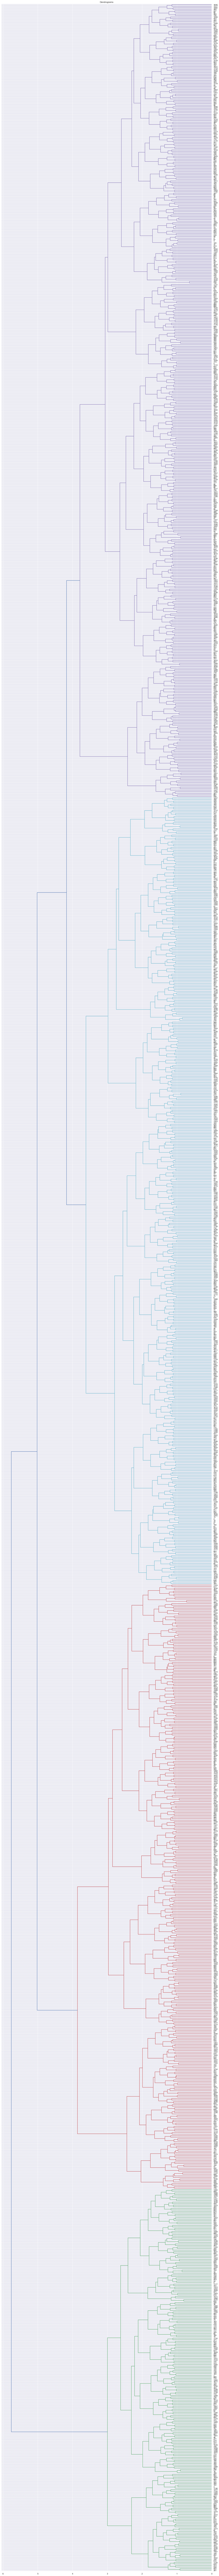

In [69]:
plt.figure(figsize=(20, 250))  
plt.title('Dendrograms')  
dend = shc.dendrogram(shc.linkage(df, method='ward'), orientation='left', leaf_font_size=10)#, truncate_mode='lastp')

In [70]:
dend['ivl']

['281',
 '922',
 '228',
 '273',
 '876',
 '1130',
 '610',
 '744',
 '1422',
 '12',
 '252',
 '149',
 '1467',
 '494',
 '1026',
 '1430',
 '354',
 '1209',
 '996',
 '1102',
 '828',
 '1616',
 '1555',
 '575',
 '734',
 '793',
 '87',
 '1372',
 '754',
 '158',
 '1348',
 '675',
 '672',
 '816',
 '94',
 '553',
 '1472',
 '15',
 '1333',
 '116',
 '1098',
 '865',
 '884',
 '878',
 '1293',
 '1302',
 '871',
 '786',
 '843',
 '1062',
 '1360',
 '1145',
 '1477',
 '1136',
 '3',
 '131',
 '306',
 '320',
 '751',
 '689',
 '1605',
 '502',
 '607',
 '160',
 '16',
 '246',
 '983',
 '1466',
 '145',
 '399',
 '165',
 '186',
 '226',
 '511',
 '635',
 '774',
 '1541',
 '1598',
 '1186',
 '1528',
 '748',
 '1029',
 '271',
 '513',
 '214',
 '277',
 '46',
 '1061',
 '891',
 '1495',
 '1601',
 '138',
 '397',
 '258',
 '849',
 '771',
 '1388',
 '370',
 '1174',
 '692',
 '1259',
 '488',
 '1195',
 '82',
 '919',
 '1462',
 '1567',
 '617',
 '999',
 '1442',
 '1514',
 '627',
 '730',
 '1268',
 '733',
 '1139',
 '1004',
 '1338',
 '303',
 '1230',
 '292

In [71]:
df.shape

(1660, 100)

In [72]:
df.reset_index()

,index,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,food,-0.221647,0.087756,-0.104437,-0.029027,-0.076270,0.090025,-0.042398,-0.045962,0.004971,...,-0.077580,0.078208,0.144950,-0.014535,0.092507,0.098769,0.043247,0.111346,0.171053,-0.005554
1,suggest,-0.180098,-0.058883,-0.017844,-0.164366,0.138615,-0.111693,-0.056773,-0.015027,0.087825,...,0.002142,0.197602,0.042128,0.068701,0.016488,-0.042837,-0.016872,-0.035549,0.028320,-0.023422
2,datum,-0.131793,0.084661,0.043776,0.199254,0.012090,0.052238,-0.003419,-0.011531,-0.035165,...,0.015344,0.040241,0.056586,0.017855,0.104821,-0.084279,0.043824,-0.062425,0.087340,0.053164
3,health,-0.159858,-0.112838,-0.093486,0.130368,0.035722,-0.027426,-0.045786,-0.103169,0.129281,...,-0.116892,0.036589,0.137533,-0.016965,-0.032410,-0.172868,-0.064915,0.069001,0.137892,0.085748
4,find,-0.106958,-0.116701,0.036716,0.034202,-0.129474,0.008109,-0.063658,-0.109975,0.037788,...,0.071637,0.220657,0.032901,0.050105,0.181583,-0.137548,-0.051440,-0.045751,-0.158588,0.042330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,microwear,0.207201,-0.013404,0.055747,0.026618,0.008718,0.017279,-0.131634,-0.059980,-0.177301,...,0.016017,-0.026558,0.066624,0.107728,0.266767,0.115343,-0.082399,0.022978,0.166509,0.149172
1656,layer,-0.038729,0.037384,0.020062,0.120963,0.086026,-0.005469,-0.023534,-0.077490,0.038008,...,0.112182,0.152516,0.019601,0.140605,0.214891,0.138719,0.100966,-0.067194,-0.153172,0.150479
1657,t,0.047943,0.099456,0.091719,0.089507,0.089423,0.033801,-0.010974,-0.199908,0.034898,...,0.081385,0.025623,-0.063014,-0.003748,0.099438,-0.153994,0.030163,-0.074706,0.105142,0.024186
1658,reference_gene,0.200165,0.020389,-0.026072,0.086390,-0.200423,0.149761,0.169541,0.060707,-0.099237,...,0.002730,0.122945,0.152909,-0.015953,0.053134,-0.039269,0.081224,0.057803,0.024373,0.008475


In [73]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
food,-0.221647,0.087756,-0.104437,-0.029027,-0.076270,0.090025,-0.042398,-0.045962,0.004971,0.005910,...,-0.077580,0.078208,0.144950,-0.014535,0.092507,0.098769,0.043247,0.111346,0.171053,-0.005554
suggest,-0.180098,-0.058883,-0.017844,-0.164366,0.138615,-0.111693,-0.056773,-0.015027,0.087825,0.019140,...,0.002142,0.197602,0.042128,0.068701,0.016488,-0.042837,-0.016872,-0.035549,0.028320,-0.023422
datum,-0.131793,0.084661,0.043776,0.199254,0.012090,0.052238,-0.003419,-0.011531,-0.035165,0.014412,...,0.015344,0.040241,0.056586,0.017855,0.104821,-0.084279,0.043824,-0.062425,0.087340,0.053164
health,-0.159858,-0.112838,-0.093486,0.130368,0.035722,-0.027426,-0.045786,-0.103169,0.129281,0.021794,...,-0.116892,0.036589,0.137533,-0.016965,-0.032410,-0.172868,-0.064915,0.069001,0.137892,0.085748
find,-0.106958,-0.116701,0.036716,0.034202,-0.129474,0.008109,-0.063658,-0.109975,0.037788,0.058265,...,0.071637,0.220657,0.032901,0.050105,0.181583,-0.137548,-0.051440,-0.045751,-0.158588,0.042330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
microwear,0.207201,-0.013404,0.055747,0.026618,0.008718,0.017279,-0.131634,-0.059980,-0.177301,0.097176,...,0.016017,-0.026558,0.066624,0.107728,0.266767,0.115343,-0.082399,0.022978,0.166509,0.149172
layer,-0.038729,0.037384,0.020062,0.120963,0.086026,-0.005469,-0.023534,-0.077490,0.038008,0.071528,...,0.112182,0.152516,0.019601,0.140605,0.214891,0.138719,0.100966,-0.067194,-0.153172,0.150479
t,0.047943,0.099456,0.091719,0.089507,0.089423,0.033801,-0.010974,-0.199908,0.034898,-0.081741,...,0.081385,0.025623,-0.063014,-0.003748,0.099438,-0.153994,0.030163,-0.074706,0.105142,0.024186
reference_gene,0.200165,0.020389,-0.026072,0.086390,-0.200423,0.149761,0.169541,0.060707,-0.099237,-0.079978,...,0.002730,0.122945,0.152909,-0.015953,0.053134,-0.039269,0.081224,0.057803,0.024373,0.008475


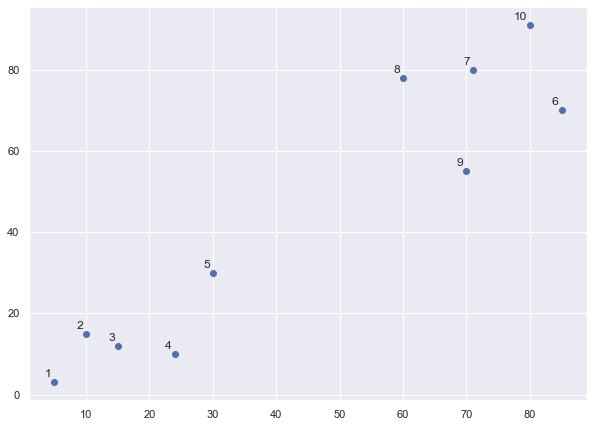

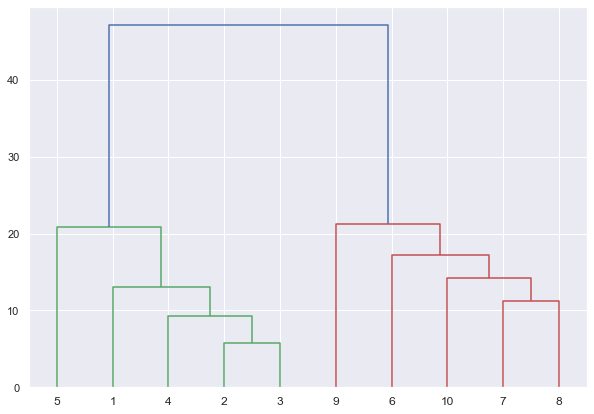

In [74]:
import numpy as np

X = np.array([[5,3],  
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])

import matplotlib.pyplot as plt

labels = range(1, 11)  
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(X[:,0],X[:,1], label='True Position')

for label, x, y in zip(labels, X[:, 0], X[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))  
dendrogram(linked,  
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

### Sub-topic analysis

Lets summarise articles containing certain key words (sub keywords). This is done manually. See **4_article_summarisation.ipynb** for the Gensim 'summarize' method.

In [75]:
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

In [76]:
# Find all sentences with sub keyword
sub_key = 'diabetes'
# plant_base_diet

In [77]:
stopwords = list(STOP_WORDS)

In [78]:
docx = nlp(docs[0])

In [79]:
# Frequency table
word_frequencies = {}
for word in docx:
    if word.text not in stopwords:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1

In [80]:
# Maximum Word Frequency
maximum_frequency = max(word_frequencies.values())
maximum_frequency
# Normalise Word Frequencies
for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequency)

In [81]:
# Sentence Tokens
sentence_list = [sentence for sentence in docx.sents]

In [82]:
# Sentence Score via comparrng each word with sentence
sentence_scores = {}  
for sent in sentence_list:  
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                #if len(sent.text.split(' ')) < 100:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent] += word_frequencies[word.text.lower()]
        # Normalise accoring to sentence length
        sentence_scores[sent] = sentence_scores[sent] / len(sent)    

In [83]:
sentence_scores

{Pregnancy tends to markedly widen the nutritional gap.: 0.37777777777777777,
 The decrease in the nutritional adequacy of observed diets of women of childbearing age cannot be solved by a simple increase in energy intake, as recommended in some countries.: 0.20625000000000002,
 A relatively good nutritional adequacy in pregnant women can therefore not be simply attributed to a higher energy intake, but to qualitative changes in the diet.: 0.22857142857142862,
 Recommendations of snack additions from public health agencies make a somewhat limited and an extremely variable contribution to tackling the nutritional gap during pregnancy.: 0.2,
 These results call for dedicated studies to define the most theoretically efficient dietary counselling during pregnancy on a methodologically sound basis, either as generic counselling for the whole population or as tailor-fitted advice at the individual level, to improve the nutritional adequacy of the diet which is jeopardized at this specific, c

In [84]:
summarized_sentences = nlargest(7, sentence_scores, key=sentence_scores.get)

In [85]:
summarized_sentences

[Pregnancy tends to markedly widen the nutritional gap.,
 A relatively good nutritional adequacy in pregnant women can therefore not be simply attributed to a higher energy intake, but to qualitative changes in the diet.,
 The decrease in the nutritional adequacy of observed diets of women of childbearing age cannot be solved by a simple increase in energy intake, as recommended in some countries.,
 Recommendations of snack additions from public health agencies make a somewhat limited and an extremely variable contribution to tackling the nutritional gap during pregnancy.,
 These results call for dedicated studies to define the most theoretically efficient dietary counselling during pregnancy on a methodologically sound basis, either as generic counselling for the whole population or as tailor-fitted advice at the individual level, to improve the nutritional adequacy of the diet which is jeopardized at this specific, critical stage of the life cycle.]